# Model VGG16

In [8]:
# Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

### Some useful parameters for the model

In [9]:
# Parameters
img_height = 100
img_width = 100
batch_size = 64
num_classes = 131
epochs = 15

### Preparing Data

In [10]:
# Generators for our data
train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    'C:/Users/Palmg/Desktop/fruits-360/Training',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'C:/Users/Palmg/Desktop/fruits-360/Training',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    'C:/Users/Palmg/Desktop/fruits-360/Test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)



Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


### Training image sample

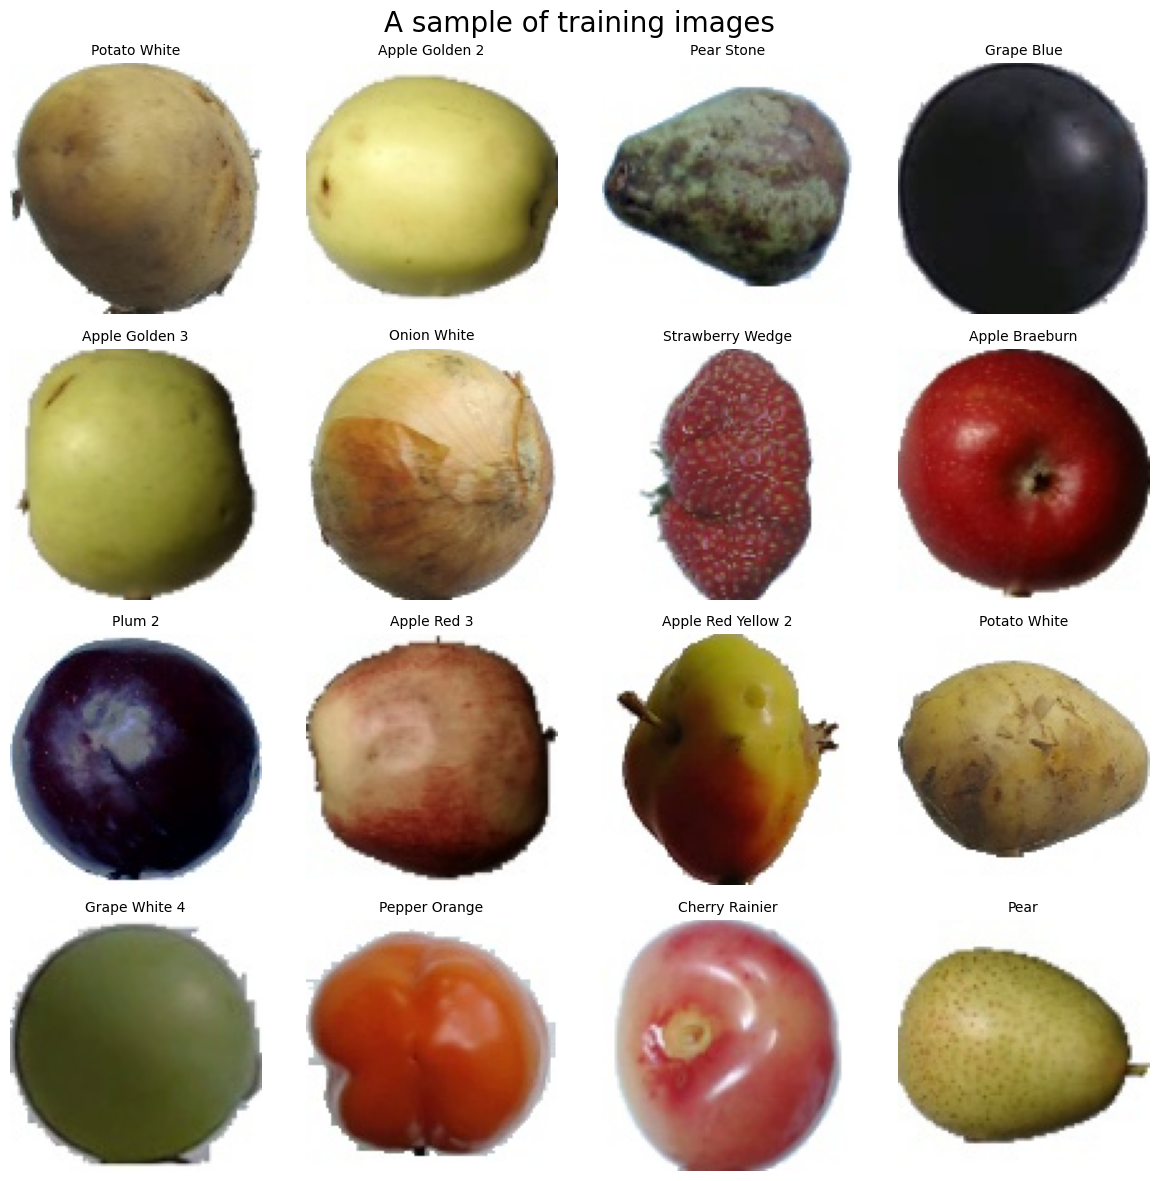

In [11]:
# Extracts a batch of train images and labels.
# The labels are one-hot encoded so we transform that to index [0,130] instead using argmax()
train_images, train_labels = next(train_generator)
train_classes = np.argmax(train_labels, axis=1)

# Define a list of class labels. These are written labels like "Orange" and "Mandarine"
class_labels = list(train_generator.class_indices.keys())

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('A sample of training images', fontsize=20)

for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[i])
    ax.axis('off')
    ax.set_title(class_labels[train_classes[i]], fontsize=10)
plt.tight_layout()
plt.show()

### Defining VGG16 model

In [12]:
# The pre-trained model
base_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_vgg16.trainable = False

# Build the model
model = Sequential()

model.add(base_vgg16)
model.add(GlobalMaxPooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 131)               67203     
                                                                 
Total params: 15,044,547
Trainable params: 329,859
Non-trainable params: 14,714,688
____________________________________

### Training

In [13]:
"""
Callback function to run all 15 epochs but then afterwards choose the best weights. (Best performing model)
Earlier version stopped training if the last 5 epochs were not improving the accuracy by at least 1%.
I decided that I want to see the whole training through.
"""
callback = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    min_delta=0.005,
    restore_best_weights=True
)

# Training
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/15
847/847 [==============================] - 762s 899ms/step - loss: 1.3000 - accuracy: 0.7068 - val_loss: 0.2505 - val_accuracy: 0.9442
Epoch 2/15
847/847 [==============================] - 697s 823ms/step - loss: 0.2071 - accuracy: 0.9534 - val_loss: 0.1134 - val_accuracy: 0.9739
Epoch 3/15
847/847 [==============================] - 700s 826ms/step - loss: 0.0947 - accuracy: 0.9800 - val_loss: 0.0849 - val_accuracy: 0.9773
Epoch 4/15
847/847 [==============================] - 699s 826ms/step - loss: 0.0585 - accuracy: 0.9878 - val_loss: 0.0695 - val_accuracy: 0.9807
Epoch 5/15
847/847 [==============================] - 699s 826ms/step - loss: 0.0452 - accuracy: 0.9899 - val_loss: 0.0771 - val_accuracy: 0.9752
Epoch 6/15
847/847 [==============================] - 701s 828ms/step - loss: 0.0326 - accuracy: 0.9924 - val_loss: 0.0751 - val_accuracy: 0.9726
Epoch 7/15
847/847 [==============================] - 701s 828ms/step - loss: 0.0308 - accuracy: 0.9920 - val_loss: 0.0683 -

In [14]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_accuracy = history.history['val_accuracy'][best_epoch - 1]
best_accuracy = history.history['accuracy'][best_epoch - 1]

# Print the results
print("VGG16 Stats", "\n")

print(f"Best Epoch was: {best_epoch}")
print(f"Accuracy: {best_accuracy}")
print(f"Validation Accuracy: {best_val_accuracy}")

VGG16 Stats 

Best Epoch was: 4
Accuracy: 0.9877652525901794
Validation Accuracy: 0.9807435870170593


### Plotting the training progress

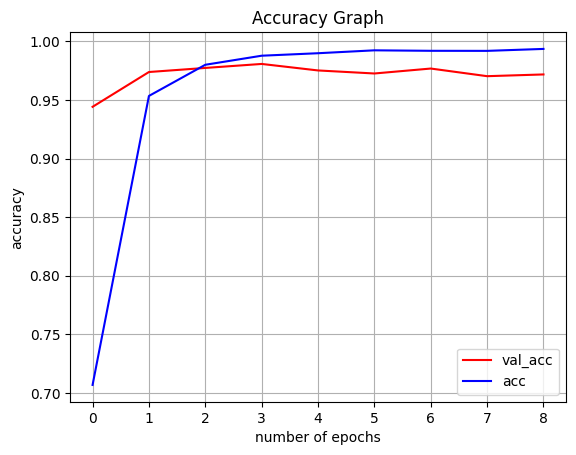

In [15]:
"""
Plotting validation accuracy and accuracy.
If validation accuracy is higher than plain accuracy its good.
Other way around it means the model is overfitting.
"""
plt.plot(history.history["val_accuracy"],color="r",label="val_acc")
plt.plot(history.history["accuracy"], color="b", label="acc" )
plt.title("Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

### Saving Model

In [16]:
model.save("/Users/Palmg/Desktop/machineLearningModels/vgg16_BSc_model.h5")

### Loading Model

In [17]:
model = load_model("/Users/Palmg/Desktop/machineLearningModels/vgg16_BSc_model.h5")

### VGG16 Predictions

2/2 [==============================] - 1s 332ms/step
<class 'numpy.ndarray'> (64, 131)
<class 'numpy.ndarray'> (64,)
130
130


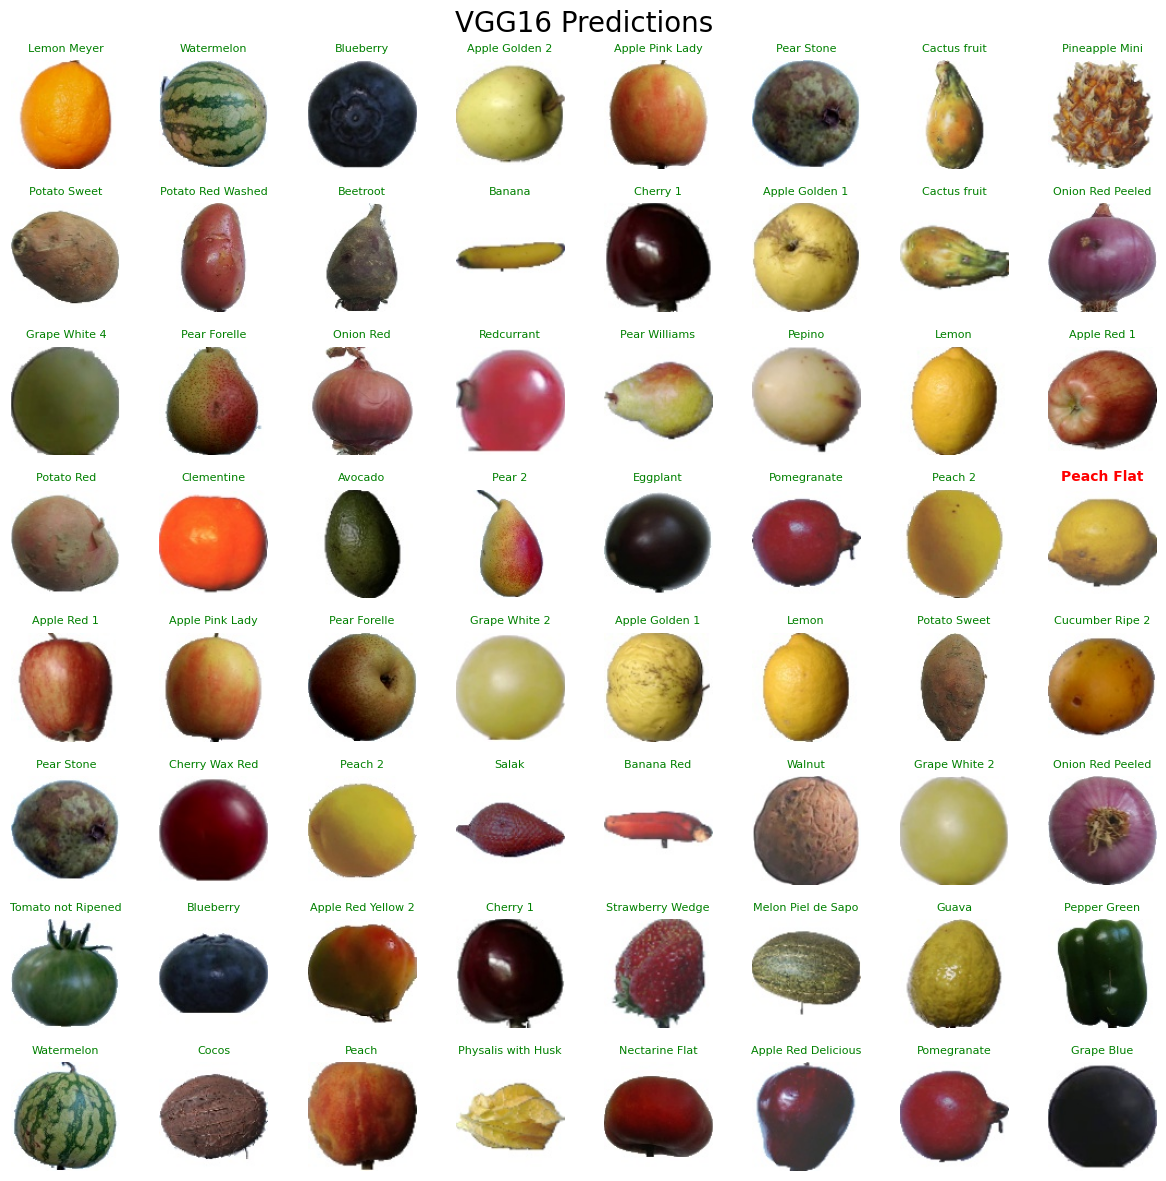

In [18]:
# Extracts a batch of test images and labels.
# The labels are one-hot encoded so we transform that to index [0,130] instead using argmax()
test_images, test_labels = next(test_generator)
test_classes = np.argmax(test_labels, axis=1)

# Get predictions for a batch of test images.
# Again we only want the index of the most probable fruit [0,130]
pred_probs = model.predict(test_images)
pred_classes = np.argmax(pred_probs, axis=1)

# Define a list of class labels
class_labels = list(test_generator.class_indices.keys())

"""
Create a 4x4 subplot of images and their predicted classes.

Labels are colored:
Green if prediction was correct
Red if prediction was wrong

Also added some extra fontweight + slightly bigger font to wrong predictions.
I want them to stand out
"""
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
fig.suptitle('VGG16 Predictions', fontsize=20)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i])
    ax.axis('off')
    if class_labels[test_classes[i]] == class_labels[pred_classes[i]]:
        ax.set_title(class_labels[pred_classes[i]], fontsize=8, color='green')
    else:
        ax.set_title(class_labels[pred_classes[i]], fontsize=10, color='red', fontweight='bold')
plt.tight_layout()
plt.show()

### Testing

* Because it turns out that all 3 models VGG16, ResNet50V2 and MobileNetV2 are very accurate >95%.
* Our plan now is to run the test images through the model 5 times and store the misclassified fruits in a list.
* Then visualize a top 10 to see if there are some misclassifications that really stand out.

In [19]:
test_loss, test_accuracy = model.evaluate(test_generator)


355/355 [==============================] - 264s 744ms/step - loss: 0.1953 - accuracy: 0.9511


In [20]:
print(f'Test accuracy: {test_accuracy}')

Test accuracy: 0.9511195421218872


In [21]:
# Generating harder test data
test_datagen_hard = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_generator_hard = test_datagen_hard.flow_from_directory(
    'C:/Users/Palmg/Desktop/fruits-360/Test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 22688 images belonging to 131 classes.


In [22]:
# Get the true labels and the predicted labels
true_labels = []
predicted_labels = []

# Run the predictions 5 times (to get more data. Roughly ~110k predictions)
for _ in range(5):
    print("Iteration:", _+1, "/ 5")
    temp_true_labels = []
    temp_predicted_labels = []

    # Iterate through the test_generator to get the true and predicted labels in the correct order
    for images, labels in test_generator_hard:
        temp_true_labels.extend(np.argmax(labels, axis=-1))
        temp_predicted_labels.extend(np.argmax(model.predict(images, verbose=0), axis=-1))
        # Break the loop once we've gone through all the test data
        if len(temp_true_labels) >= test_generator.samples:
            break

    true_labels.extend(temp_true_labels)
    predicted_labels.extend(temp_predicted_labels)
    test_generator_hard.reset

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

Iteration: 1 / 5
Iteration: 2 / 5
Iteration: 3 / 5
Iteration: 4 / 5
Iteration: 5 / 5


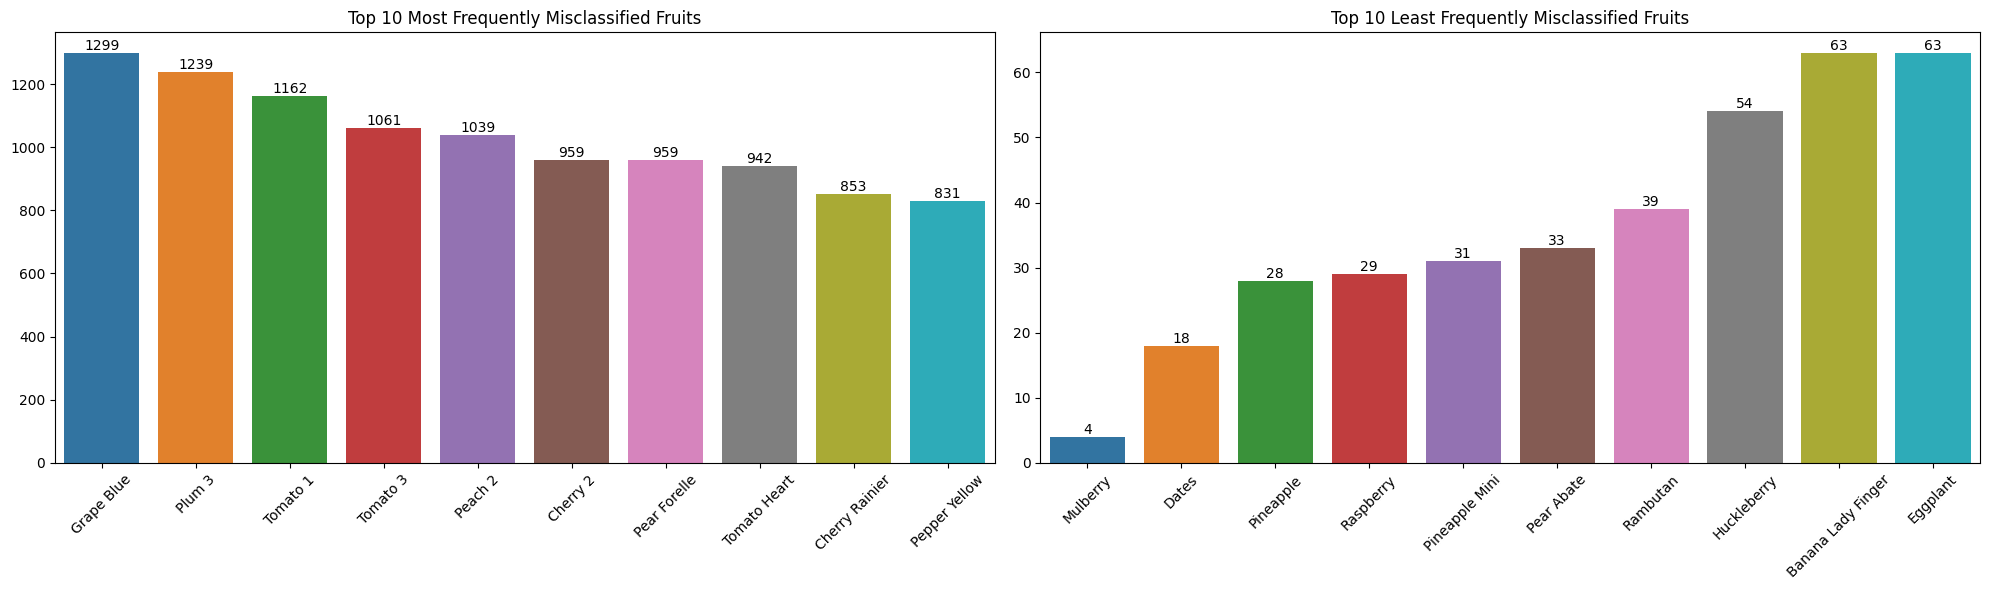

In [27]:
# Find the misclassifications
misclassified_indices = np.nonzero(predicted_labels != true_labels)[0]

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Store the misclassified fruit names
misclassified_fruits = [class_names[i] for i in true_labels[misclassified_indices]]

# Initialize misclassified_counts with all fruit classes and a count of 0
misclassified_counts = {fruit: 0 for fruit in class_names}

# Count the misclassifications for each fruit (as before)
for fruit in misclassified_fruits:
    misclassified_counts[fruit] += 1

# Rest of the code remains the same

# Get the top 10 most frequently misclassified fruits
top_10_misclassified = sorted(misclassified_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Get the top 10 least frequently misclassified fruits
top_10_least_misclassified = sorted(misclassified_counts.items(), key=lambda x: x[1])[:10]

# Create subplots for the top 10 most and least frequently misclassified fruits
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Function to add counts on top of the bars
def add_counts_on_bars(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom')

# Plot the top 10 most frequently misclassified fruits
bars_most = sns.barplot(x=[x[0] for x in top_10_misclassified], y=[x[1] for x in top_10_misclassified], ax=axes[0])
axes[0].set_title('Top 10 Most Frequently Misclassified Fruits')
axes[0].tick_params(axis='x', rotation=45)
add_counts_on_bars(axes[0], bars_most.containers[0])

# Plot the top 10 least frequently misclassified fruits
bars_least = sns.barplot(x=[x[0] for x in top_10_least_misclassified], y=[x[1] for x in top_10_least_misclassified], ax=axes[1])

axes[1].set_title('Top 10 Least Frequently Misclassified Fruits')
axes[1].tick_params(axis='x', rotation=45)
add_counts_on_bars(axes[1], bars_least.containers[0])

plt.tight_layout()
plt.show()